# Gaussian Mixture Model

This is a brief tutorial on training mixture models in Pyro. We'll focus on the mechanics of `enum_discrete` and setting up mixture weights. To simplify matters, we'll train a trivial 1-D Gaussian model on a tiny 5-point dataset.

In [1]:
import os
import sys
import torch
import numpy as np
import scipy.stats
from torch.nn import Softmax
from torch.nn.functional import softplus
from torch.autograd import Variable
from matplotlib import pyplot
%matplotlib inline

import pyro
from pyro.optim import Adam
from pyro.infer.svi import SVI
from pyro.distributions import categorical, normal
softmax = Softmax(dim=-1)
smoke_test = ('CI' in os.environ)

## Dataset

Here is our tiny dataset. It has five points.

In [2]:
data = Variable(torch.Tensor([0, 1, 10, 11, 12]))

## Maximum likelihood approach

Let's start by optimizing model parameters `ps`, `mu`, and `sigma`, rather than treating them as random variables with priors. Our model will learn global mixture weights, the mean of each mixture component, and a shared variance that is common to both components. Our guide will learn soft assignment weights of each point. Note that none of our parameters have priors, so this approach is not fully Bayesian.

In [3]:
K = 2  # Fixed number of components.

def model(data):
    # Global parameters.
    ps = softmax(pyro.param('unconstrained_ps', Variable(torch.zeros(K), requires_grad=True)))
    ps = ps.view(1, -1).expand(len(data), -1)
    mu = pyro.param('mu', Variable(torch.normal(torch.zeros(K), torch.ones(K)),
                                   requires_grad=True))
    sigma = softplus(pyro.param('unconstrained_sigma',
                                Variable(torch.Tensor([-1]), requires_grad=True)))

    # Local parameters.
    with pyro.iarange('data'):
        # Until Pyro 0.2, we'll have to .squeeze() and .unsqeeze() to satisfy iarange.
        z = pyro.sample('z', categorical, ps).squeeze(-1)
        mu_z = mu.index_select(0, z).unsqueeze(-1)
        pyro.sample('x', normal, mu_z, sigma.expand_as(mu_z), obs=data.unsqueeze(-1))

def guide(data):
    with pyro.iarange('data'):
        p = softmax(pyro.param('unconstrained_p',
                               Variable(torch.zeros(len(data), K), requires_grad=True)))
        pyro.sample('z', categorical, p)

To run inference with this `(model,guide)` pair, we use Pyro's `enum_discrete` option to enumerate over all assignments in each iteration. Since we've wrapped the batched categorical assignments in a `pyro.iarange` indepencence context, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than `2**len(data) = 32`.

In [4]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
inference = SVI(model, guide, optim, 'ELBO', enum_discrete=True)

In [5]:
pyro.set_rng_seed(0)            # Set seed to make results reproducible.
pyro.get_param_store().clear()  # Clear stale param values.
loss = []
for i in range(200 if not smoke_test else 2):
    inference.step(data)
    loss.append(inference.step(data))
    sys.stdout.write('.' if i % 80 else '\n')
    sys.stdout.flush()


...............................................................................
...............................................................................
.......................................

Text(0.5,1,u'Convergence of SVI')

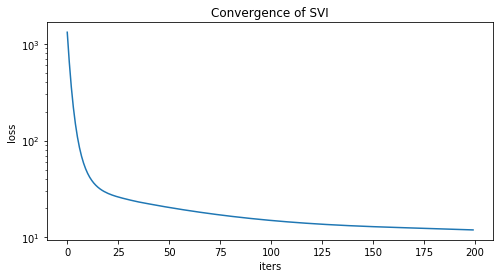

In [6]:
pyplot.figure(figsize=(8,4)).set_facecolor('white')
pyplot.plot(loss)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI')

Here are the learned parameters:

In [7]:
ps = softmax(pyro.param('unconstrained_ps'))
mu = pyro.param('mu')
sigma = softplus(pyro.param('unconstrained_sigma'))
print('ps = {}'.format(ps.data.numpy()))
print('mu = {}'.format(mu.data.numpy()))
print('sigma = {}'.format(sigma.data.numpy()))

ps = [ 0.5992229   0.40077707]
mu = [ 10.93902969   0.55254382]
sigma = [ 2.09332943]


The model's `ps` are as expected, with 3/5 of the data in the first component and 2/3 in the second component. We can also examine the guide's local `p` variable which can be interpreted as assignment probabilities.

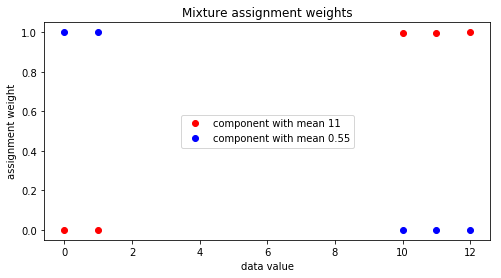

In [8]:
p = softmax(pyro.param('unconstrained_p'))
pyplot.figure(figsize=(8, 4)).set_facecolor('white')
pyplot.plot(data.data.numpy(), p.data.numpy()[:,0], 'ro',
            label='component with mean {:0.2g}'.format(mu.data[0]))
pyplot.plot(data.data.numpy(), p.data.numpy()[:,1], 'bo',
            label='component with mean {:0.2g}'.format(mu.data[1]))
pyplot.title('Mixture assignment weights')
pyplot.xlabel('data value')
pyplot.ylabel('assignment weight')
pyplot.legend(loc='center');

Next let's visualize the mixture model.

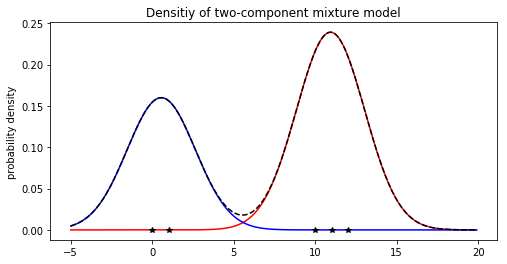

In [9]:
X = np.arange(-5,20,0.1)
Y1 = ps.data[0] * scipy.stats.norm.pdf((X - mu.data[0]) / sigma.data[0])
Y2 = ps.data[1] * scipy.stats.norm.pdf((X - mu.data[1]) / sigma.data[0])

pyplot.figure(figsize=(8, 4)).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density');

Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observed that the mixture model gets stuck in an everthing-in-one-cluster hypothesis if `sigma` is initialized to be too large.